## **Загрузка данных**

In [1]:
import pandas as pd
import seaborn as sns
from scipy.stats import chi2_contingency
import matplotlib.pyplot as plt
import pandahouse as ph
import requests
import json
from urllib.parse import urlencode

plt.style.use('ggplot')

In [2]:
def load_file_in_yandex(public_key):
    base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
    public_key = public_key
    # Получаем загрузочную ссылку
    final_url = base_url + urlencode(dict(public_key=public_key))
    response = requests.get(final_url)
    
    h = json.loads(response.text)['href']  # 'парсинг' ссылки на скачивание
    
    return h

### Функция, которая строит графики по получаемым метрикам

In [3]:
def build_plot(data, m_1, m_2, m_3):
    plt.figure(figsize=(16, 5))
  
    plt.subplot(1, 3, 1)
    sns.barplot(data=data, y=m_1, x='grp')
    plt.title(m_1)

    # Две строки, два столбца. Текущая ячейка - 3
    plt.subplot(1, 3, 2)
    sns.barplot(data=data, y=m_2, x='grp')  
    plt.title(m_2)

    # Две строки, два столбца. Текущая ячейка - 2
    plt.subplot(1, 3, 3)
    sns.barplot(data=data, y=m_3, x='grp')  
    plt.title(m_3)

    plt.show()

### Файл с информацией о принадлежности пользователя к контрольной или экспериментальной группе (А – контроль, B – целевая группа) 

In [4]:
groups = pd.read_csv(load_file_in_yandex('https://disk.yandex.ru/d/UhyYx41rTt3clQ'),
                     sep=';', error_bad_lines=False, comment='#', encoding='cp1251')

In [5]:
groups.shape

(74484, 2)

In [6]:
groups.id.nunique()

74484

In [7]:
groups.isnull().mean()

id     0.0
grp    0.0
dtype: float64

В таблице все айди уникальны, пропущенных значений нет

### Файл с информацией о пользователях, которые зашли на платформу в дни проведения эксперимента

In [8]:
active_studs = pd.read_csv(load_file_in_yandex('https://disk.yandex.ru/d/Tbs44Bm6H_FwFQ'), 
                           sep=';', error_bad_lines=False, comment='#', encoding='cp1251')

In [9]:
active_studs.shape

(8341, 1)

In [10]:
active_studs.student_id.nunique()

8341

In [11]:
active_studs.student_id.isnull().mean()

0.0

Все айди уникальны, пропусков нет. Переименую столбец в 'id' для дальнейшего удобства. Так же добавлю колонку с единицами для удобства последующего подсчета активных пользователей

In [12]:
active_studs = active_studs.rename(columns={'student_id': 'id'})

In [13]:
active_studs['activ'] = 1

In [14]:
active_studs.head()

,id,activ
0,581585,1
1,5723133,1
2,3276743,1
3,4238589,1
4,4475369,1


### Файл с информацией об оплатах пользователей в дни проведения эксперимента

In [15]:
checks = pd.read_csv(load_file_in_yandex('https://disk.yandex.ru/d/pH1q-VqcxXjsVA'), 
                     sep=';', error_bad_lines=False, comment='#', encoding='cp1251')

In [16]:
checks.shape

(541, 2)

In [17]:
checks.student_id.nunique()

541

In [18]:
checks.student_id.isnull().mean()

0.0

Все айди уникальны, пропусков нет. Так же переименую столбец для удобства и добавлю столбец с единицами для подсчена купивших курс

In [19]:
checks = checks.rename(columns={'student_id': 'id'})

In [20]:
checks['cheks'] = 1

In [21]:
checks.head()

,id,rev,cheks
0,1627,990.0,1
1,3185,690.0,1
2,25973,690.0,1
3,26280,690.0,1
4,100300,990.0,1


За основу беру таблицу active_studs, так как именно эти студены участвовали в эксперименте и могли оценить новую механику оплаты

## **Общая таблица. Проверка данных**

In [22]:
studs = active_studs.merge(groups, how='left', on='id').merge(checks, how='left', on='id')

In [23]:
studs.shape

(8341, 5)

In [24]:
studs.nunique()

id       8341
activ       1
grp         2
rev        38
cheks       1
dtype: int64

In [25]:
studs.isnull().mean()

id       0.000000
activ    0.000000
grp      0.001559
rev      0.953003
cheks    0.953003
dtype: float64

In [29]:
studs[studs['grp'].isnull() == True].shape

(13, 5)

Проверяю наличие пустых значений. В столбце grp присутствуют пустные значения, следовательно есть студенты, которые заходили на платформу, но группа им не присвоена. Для изучения результатов проведения теста данных студентов необходимо исключить из таблицы.
В столбце rev есть пустые значения, что естественно,так как не все студенты за отчетный период совершали покупки

In [29]:
studs = studs.dropna(subset=['grp'], axis=0)

In [30]:
studs.isnull().mean()

id       0.00000
activ    0.00000
grp      0.00000
rev      0.95305
cheks    0.95305
dtype: float64

In [31]:
checks['rev'].sum()

573326.0035999999

In [32]:
studs['rev'].sum()

465894.00350000005

In [33]:
t = checks.merge(active_studs, how='left', on='id')

In [34]:
t['rev'].sum()

573326.0035999999

In [35]:
t[t['activ'].isnull() == True]

,id,rev,cheks,activ
1,3185,690.0,1,NaN
2,25973,690.0,1,NaN
3,26280,690.0,1,NaN
5,100645,630.0,1,NaN
6,102534,580.0,1,NaN
...,...,...,...,...
508,5291900,199.0,1,NaN
512,5331842,290.0,1,NaN
521,5486319,199.0,1,NaN
530,5562806,398.0,1,NaN


149 студентов, у которых была оплата за измеряемый период, но не было входа

Сумма оплаты в общей таблице, созданной на основе заходивших на платформу студентов не сходится с суммой в таблице оплаты. Значит есть студенты, кто не заходил на платформу, но оплата прошла по ним. Для расчета метрик за пользователей буду брать таблицу активных студентов, кто заходил на платформу в течении контрольного периода. Принимаю решение, что 149 студентов, которые оплатили, но не посещали сайт, были там ранее и у них уже была ссылка на оплату либо какой-то автоматический платеж. Соответственно новую механику оплаты услуг они не видели и как она повлияла на принятие решения на оплату узнать невозможно

In [36]:
studs[['activ', 'rev', 'cheks']] = studs[['activ', 'rev', 'cheks']].fillna(0)

In [37]:
studs.isnull().mean()

id       0.0
activ    0.0
grp      0.0
rev      0.0
cheks    0.0
dtype: float64

In [38]:
control = studs[studs['grp'] == 'A']

In [39]:
pilot = studs[studs['grp'] == 'B']

In [40]:
sum_by_cheks = studs.groupby('grp', as_index=False).agg({'rev': 'sum', 'cheks': 'sum'})

In [41]:
sum_by_cheks['mean_chek'] = sum_by_cheks.rev / sum_by_cheks.cheks

In [42]:
sum_by_cheks

,grp,rev,cheks,mean_chek
0,A,72820.0000,78.0,933.589744
1,B,393074.0035,313.0,1255.827487


In [43]:
t = studs.groupby(['grp', 'rev'], as_index=False).agg({'id': 'count'})

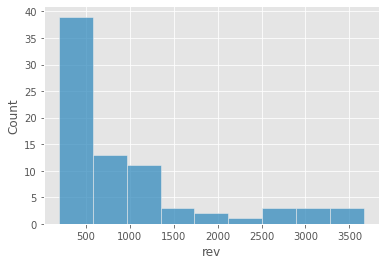

In [44]:
sns.histplot(control[control['rev'] > 0].rev)

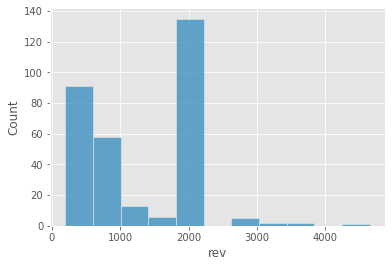

In [45]:
sns.histplot(pilot[pilot['rev'] > 0].rev)

In [46]:
pilot['rev'].value_counts().head()

0.0000       6480
1900.0000      92
290.0000       45
1900.0001      35
199.0000       27
Name: rev, dtype: int64

In [47]:
control['rev'].value_counts().head()

0.0      1457
290.0      25
580.0       6
590.0       5
199.0       5
Name: rev, dtype: int64

In [48]:
not_1900 = pilot[~pilot['rev'].isin([1900, 1900.0001])]

In [49]:
not_1900['rev'].sum() / not_1900['cheks'].sum()

815.989247311828

На основе полученной таблицы видно, что сумма среднего чека различается между тестовой и контрольной группами. В тестовой группе она выше на 344р. 
Но так же на графиках видно, что в тестовой группе есть крупный выброс в виде курса, стоимостью 1900р (93 и 35 покупок). В тестовой группе нет оплат с такой стоимостью.
Если из тестовой группы убрать оплаты по 1900 и 1900.0001(считаю их равнозначными), то видно, что средняя стоимость курса даже уменьшилась.
Возможно в период проведения теста тестовой группе так же добавили какую то акцию, что подвергает сомнению в принципе проведение всего теста. 
На основе вышеизложенной информации делаю вывод, что наиболее информативной  метрикой для изучения статитстической значимости проведенного теста можно взять конверсию в покупку (CR)

In [69]:
# Функция для расчета метрик
def metrics(studs):
    df_metrics = studs.groupby('grp', as_index=False)[['activ', 'cheks', 'rev']].agg('sum') \
        .assign(ARPU=lambda x: round((x.rev / x.activ), 2),
                ARPPU=lambda x: round((x.rev / x.cheks), 2),
                CR=lambda x: round((x.cheks / x.activ) * 100, 2))
    return (df_metrics)

In [56]:
df_metrics = metrics(studs)

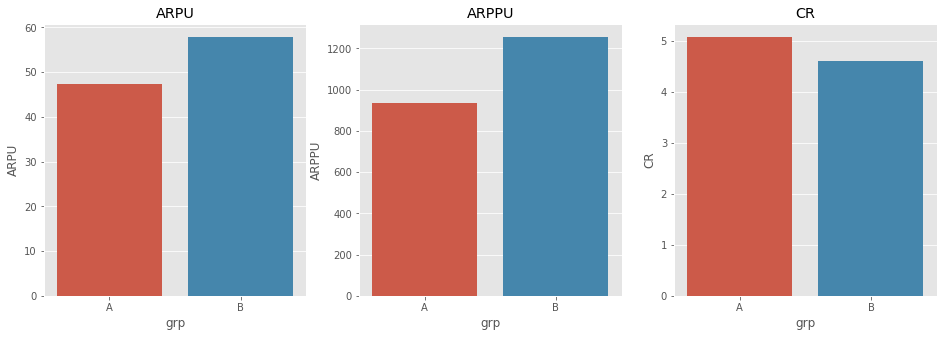

In [57]:
build_plot(df_metrics, 'ARPU', 'ARPPU', 'CR')

## **Проверка гипотез**

Так как в столбце studs.cheks у нас есть информация о том, что студент заходил на платформу (0) и совершил оплату (1) понимаем, что имеем дело с категориальными переменными. Поэтому для проверки нулевой гипотезы используем Хи-квадрат. Для это строим сводную таблицу

In [58]:
CR = studs.groupby('grp', as_index=False).agg({'cheks': ['sum', 'count']})

In [59]:
CR = CR.pivot_table(columns='grp')

/opt/tljh/user/lib/python3.7/site-packages/pandas/core/frame.py:6831: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  observed=observed,
/opt/tljh/user/lib/python3.7/site-packages/pandas/core/generic.py:3884: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


In [60]:
CR

grp               A       B
cheks count  1535.0  6793.0
      sum      78.0   313.0

In [61]:
c, p, dof, expected = chi2_contingency(CR) 
print(p)

0.4912034030799808


Значение p_value выше 5%, значит мы не можем отвергнуть нулевую гипотезу. Принимаем, что между группами А и В нет разницы. 
***Вывод:*** не стоит запускать новую механику оплаты для всех пользователей. Либо необходимо провести еще один подобный тест, но без каких-либо маркетинговых нововведений в этот период, для точной и честной оценки 

## **Дополнительный файл с пользователями**




In [62]:
group_add = pd.read_csv(load_file_in_yandex('https://disk.yandex.ru/d/5Kxrz02m3IBUwQ'), 
                        sep=',', error_bad_lines=False, comment='#', encoding='cp1251')

Функция которая автоматически подгружает информацию из дополнительного файла group_add

In [70]:
def add_new_data(groups, group_add, active_studs, checks):
    groups_all = groups.append(group_add)

    # Приведу все столбцы с id к одному названию
    groups_all.rename(columns={groups_all.columns[0]: 'id'}, inplace=True)
    groups.rename(columns={groups.columns[0]: 'id'}, inplace=True)
    active_studs.rename(columns={active_studs.columns[0]: 'id'}, inplace=True)
    checks.rename(columns={checks.columns[0]: 'id'}, inplace=True)

    # Проставляю 1, чтобы в общей таблице удобно было деть подсчет действий
    active_studs['activ'] = 1
    checks['cheks'] = 1

    # Собираю общую таблицу для просчета метрик 
    new_studs = active_studs \
        .merge(groups_all, how='left', on='id') \
        .merge(checks, how='left', on='id') \
        .dropna(subset=['grp'], axis=0) \
        .fillna(0)

    # Расчет метрик
    new_metrics = metrics(new_studs)
    return (new_metrics)

In [64]:
new_metrics = add_new_data(groups, group_add, active_studs, checks)
new_metrics

,grp,activ,cheks,rev,ARPU,ARPPU,CR
0,A,1538,78.0,72820.0000,47.35,933.59,5.07
1,B,6803,314.0,394974.0035,58.06,1257.88,4.62


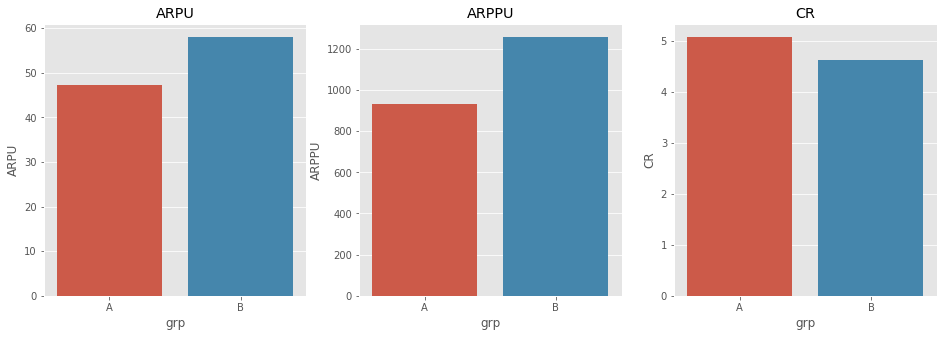

In [65]:
build_plot(new_metrics, 'ARPU', 'ARPPU', 'CR')

# **SQL**

## Соединение с базой и загрузка данных

In [66]:
connection_default = {'host': 'http://clickhouse.beslan.pro:8080',
                      'database': 'default',
                      'user': 'student', 
                      'password': 'dpo_python_2020'}

In [143]:
q = '''
     SELECT
        st_id,
        toDateTime(timest) as timest,
        correct,
        subject
     FROM
        default.peas
    '''

In [144]:
peas = ph.read_clickhouse(query=q, connection=connection_default)

In [145]:
q = '''
     SELECT
        st_id,
        toDateTime(sale_time) as sale_time,
        money,
        subject
     FROM
        default.final_project_check
    '''

In [146]:
final_project_check = ph.read_clickhouse(query=q, connection=connection_default)

In [147]:
q = '''
     SELECT
        st_id,
        test_grp
     FROM
        default.studs
    '''

In [148]:
studs = ph.read_clickhouse(query=q, connection=connection_default)

Функция для выполнения запроса

In [149]:
def select(sql):
    return ph.read_clickhouse(query=sql, connection=connection_default)

## Количество очень усердных учеников

In [150]:
sql = '''
    select count(st_id) as count_diligent_st
    from (select p.st_id, sum(p.correct)
        from peas p
        group by p.st_id
        having sum(p.correct) >= 20)
'''

In [151]:
select(sql)

,count_diligent_st
0,136


## Оптимизация воронки

In [152]:
sql = '''
with money as (
select st_id, sum_money, activs, test_grp
from (
    select st_id, activs, test_grp, sum_money
    from (
        select s.st_id,
        p.correct as activs,
        s.test_grp
        from studs s left join (
            select st_id, sum(correct) as correct
            from peas
            group by st_id) p 
        on s.st_id = p.st_id) s left join (
            select st_id, sum(money) as sum_money
            from final_project_check
            group by st_id
        ) m on s.st_id = m.st_id)),

math_studs as (
select p.st_id as st_id, p.corrected as cor_math,
f.money as money_math, s.test_grp as test_grp
from (select p.st_id, sum(p.correct) as corrected
    from peas p
    group by(p.st_id)
    having p.subject='Math' and sum(p.correct)>=2) p
    left join (select f.st_id, f.money
                from final_project_check f
                where f.subject='Math') f
    on p.st_id=f.st_id
    left join studs s
    on p.st_id=s.st_id)

select m.test_grp as grp, 
round(avg(m.sum_money), 2) as ARPU,
round(sumIf(m.sum_money, m.activs > 10)/countIf(m.st_id, m.activs > 10), 2) as ARPAU,
round(countIf(m.st_id, m.sum_money > 0)/count(m.st_id)*100, 2) as CR,
round(countIf(m.st_id, m.sum_money > 0 and m.activs > 10)/countIf(m.st_id, m.activs > 10)*100, 2) as CR_activ,
round(countIf(s.st_id, s.money_math>0)/countIf(s.st_id, s.cor_math>0)*100, 2) as CR_math
from money m left join math_studs s on m.st_id=s.st_id
group by m.test_grp
'''
select(sql)

,grp,ARPU,ARPAU,CR,CR_activ,CR_math
0,control,4540.98,10393.70,4.92,11.02,6.12
1,pilot,11508.47,29739.58,10.85,26.04,9.52


In [154]:
t = select(sql)

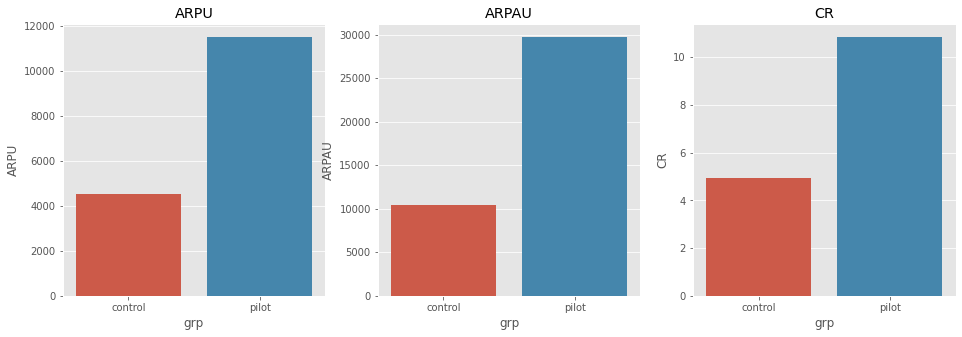

In [155]:
build_plot(t, 'ARPU', 'ARPAU', 'CR')